# Using _egobox_ surrogate model _Gpx_

## Installation

In [1]:
# %pip install egobox

We import _egobox_ as _egx_ for short

In [2]:
import egobox as egx

# To display debug information (none by default)
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Example 1 : Gpx basics

### Training 

#### Training data definition

In [3]:
import numpy as np

xt = np.array([0.0, 1.0, 2.0, 3.0, 4.0]).T
yt = np.array([0.0, 1.0, 1.5, 0.9, 1.0])

#### Building the surrogate

In [4]:
gpx = egx.Gpx.builder().fit(xt, yt)

### Prediction

#### Using the surrogate for estimation

In [5]:
# number of x locations to estimate
num = 100

# x should have 2D shape (nsamples, nx)
x = np.linspace(0.0, 4.0, num).reshape((-1, 1))

# estimated values
y = gpx.predict(x)
# estimated variances
s2 = gpx.predict_var(x)

# Print hyperparameters
print(f"Optimal theta = {gpx.thetas()[0]}")
print(f"GP variance = {gpx.variances()[0]}")
print(f"Reduced likelihood = {gpx.likelihoods()[0]}")

Optimal theta = [1.83209405]
GP variance = 0.30494058899172644
Reduced likelihood = 0.5781740714613353


#### Plotting results

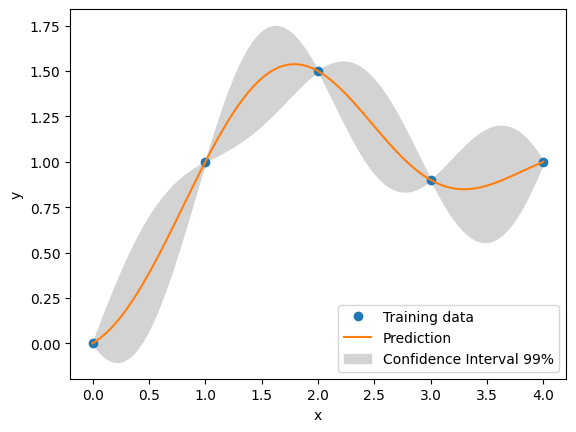

In [6]:
import matplotlib.pyplot as plt

def plot_gp(xt, yt, x, y, s2):
    fig, axs = plt.subplots(1)
    
    # training data
    axs.plot(xt, yt, "o")
    
    # gp mean
    axs.plot(x, y)
    
    # 99% confidence interval
    axs.fill_between(
        np.ravel(x),
        np.ravel(y - 3 * np.sqrt(s2)),
        np.ravel(y + 3 * np.sqrt(s2)),
        color="lightgrey",
    )
    
    # legend
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    axs.legend(
        ["Training data", "Prediction", "Confidence Interval 99%"],
        loc="lower right",
    )
    return axs

plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [7]:
# number fo trajectories to sample
n_traj = 30

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

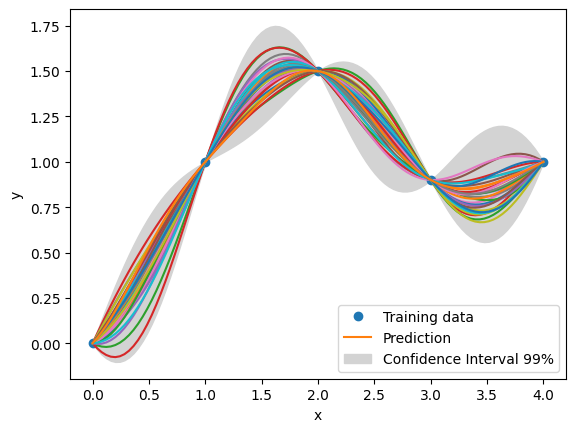

In [8]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 2 : Gpx trend and correlation models customization, saving and loading

### Test function

$$f : \left\{ \begin{array}{c} [-10, 10] \rightarrow \mathbb{R} \\ x \mapsto x^2 \sin(x) \ \end{array} \right.$$

In [9]:
import numpy as np

def f(x):
    return x**2 * np.sin(x)

### Training

$f$ is approximated with _Gpx_ at points $-8.5$,  $-4.0$,  $-3.0$,  $-1.0$, $4.0$ and  $7.5$. 

In [10]:
xt = np.array([[-8.5, -4.0, -3.0, -1.0, 4.0, 7.5]]).T
yt = f(xt)

To show features of _Gpx_, below, we build the surrogate asking for best GP regression by testing constant, linear or quadratic trend with either squared_exponential or matern52. The quality of the surrogate is assessed by cross validation.

In [11]:
gpx_builder = egx.Gpx.builder(regr_spec=egx.RegressionSpec.ALL, 
                              corr_spec=egx.CorrelationSpec.SQUARED_EXPONENTIAL | egx.CorrelationSpec.MATERN52)
gpx = gpx_builder.fit(xt, yt)

We can get string representations of the trained GP

In [12]:
print(f"Gpx string: {gpx}")
print(f"Gpx stringified JSON serialization {repr(gpx)}")

Gpx string: Mixture[Hard](Linear_Matern52GP(mean=LinearMean, corr=Matern52, theta=[5.0328871070499], variance=436.955745703778, likelihood=3.0156045880805125))
Gpx stringified JSON serialization {"recombination":"Hard","experts":[{"type":"GpLinearMatern52Surrogate","theta":{"v":1,"dim":[1],"data":[5.0328871070499]},"likelihood":3.0156045880805125,"inner_params":{"sigma2":436.955745703778,"beta":{"v":1,"dim":[2,1],"data":[-0.08079444624150181,0.8013224068213923]},"gamma":{"v":1,"dim":[6,1],"data":[-0.43929102536598014,1.0535723606119747,-0.2754976528715771,0.11573602645764448,-0.9081304602629857,0.4536107514309231]},"r_chol":{"v":1,"dim":[6,6],"data":[1.000000000000011,0.0,0.0,0.0,0.0,0.0,0.005454068676745515,0.9999851264568346,0.0,0.0,0.0,0.0,0.0010949149447086568,0.599721697123781,0.8002079024605155,0.0,0.0,0.0,0.00003838851181451278,0.052444206799343994,0.2125141897806854,0.9757496209793735,0.0,0.0,5.7184920782253075e-9,0.000016269366709007347,0.00010018456762541182,0.002500373384432

... and save it in a json file (for a human readable format) or in binary file (for optimizing performances).

In [13]:
gpx.save("gp.json")  # json extension is automatically detected hence json file format
gpx.save("gp.bin")   # otherwise binary (you can compare here the size on disk)

True

We can reload it with

In [14]:
gpx = egx.Gpx.load("gp.json")

### Prediction

In [15]:
x_min, x_max = -10, 10
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict(x)
s2 = gpx.predict_var(x)

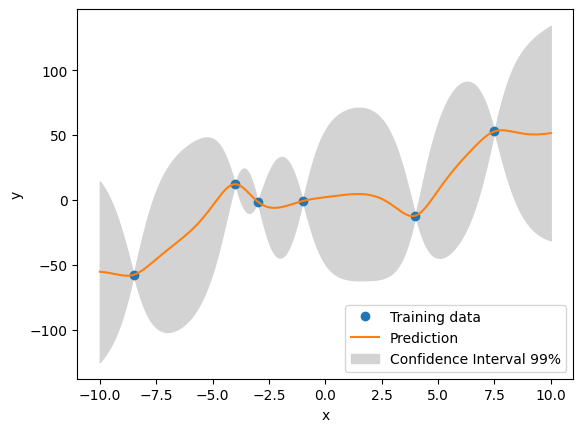

In [16]:
plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [17]:
# number fo trajectories to sample
n_traj = 10

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

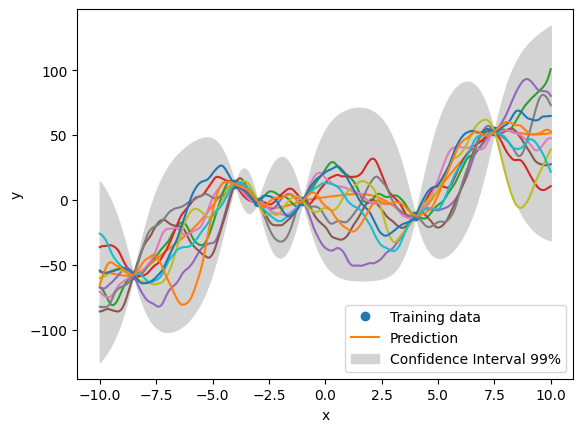

In [18]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 3 : Clustering

### Test function

We are going to use a test function with three modes to show clustering feature

In [19]:
def function_3modes(x):
    y = np.zeros(x.shape)
    y[x < 0.4] = x[x < 0.4] ** 2
    y[(x >= 0.4) & (x < 0.8)] = 3 * x[(x >= 0.4) & (x < 0.8)] + 1
    y[x >= 0.8] = np.sin(10 * x[x >= 0.8])
    return y

### Training 

#### Training data definition

In [20]:
np.random.seed(42)  # results may differ depending on training data, set seed here for reproducibility
xt = np.random.sample(60).reshape((-1, 1))
yt = function_3modes(xt)

#### Building the surrogate

In [21]:
gpx = egx.Gpx.builder(n_clusters=3).fit(xt, yt)

In [22]:
print(gpx)

Mixture[Hard](Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.23668177036771978], variance=0.02636933230380325, likelihood=278.24947267393634), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.12363257893773698], variance=1.4576812259587242, likelihood=192.54870518074517), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.24725603231228033], variance=0.9800473934197045, likelihood=89.03911854382321))


We see that 3 experts are smoothly recombined with an heasviside factor of 0.1 automatically adjusted to improve the overall surrogate quality.

### Plotting

In [23]:
x_min, x_max = 0, 1
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict(x)
s2 = gpx.predict_var(x)

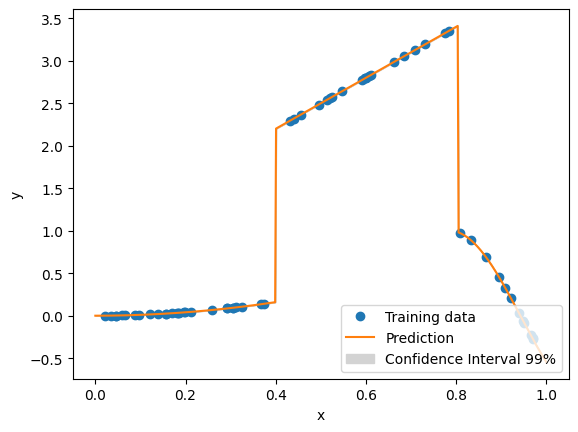

In [24]:
plot_gp(xt, yt, x, y, s2)
plt.show()

We can check it is better than one cluster (the default).

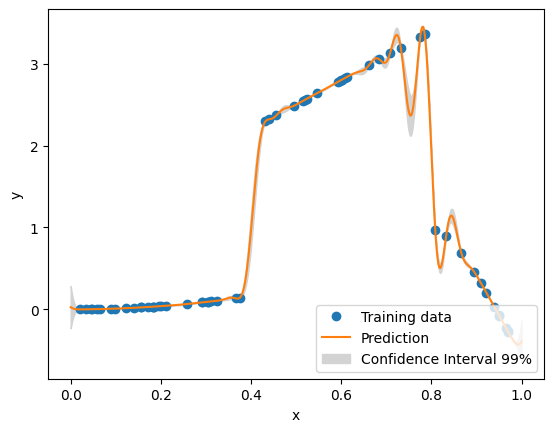

In [25]:
gpx = egx.Gpx.builder().fit(xt, yt)
y = gpx.predict(x)
s2 = gpx.predict_var(x)
plot_gp(xt, yt, x, y, s2)
plt.show()

We can also let _Gpx_ find the  best number of clusters

(60, 1)
Mixture[Hard](Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.23668177036771978], variance=0.02636933230380325, likelihood=278.24947267393634), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.12363257893773698], variance=1.4576812259587242, likelihood=192.54870518074517), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.24725603231228033], variance=0.9800473934197045, likelihood=89.03911854382321))


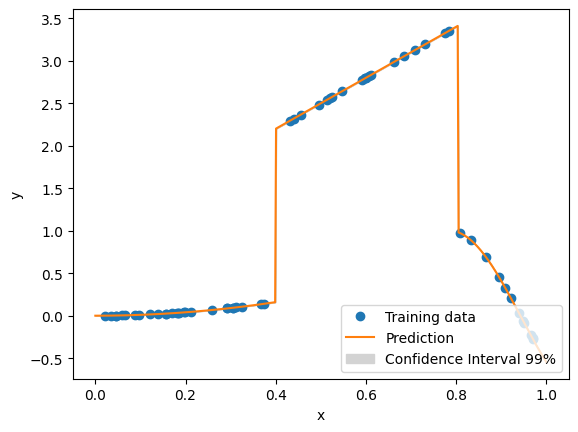

In [26]:
print(yt.shape)
gpx = egx.Gpx.builder(n_clusters=0).fit(xt, yt)
print(gpx)
y = gpx.predict(x)
s2 = gpx.predict_var(x)
plot_gp(xt, yt, x, y, s2)
plt.show()

## Gpx API

In [27]:
help(egx.Gpx.builder())

Help on GpMix in module builtins object:

class GpMix(object)
 |  GpMix(regr_spec=Ellipsis, corr_spec=Ellipsis, kpls_dim=None, n_clusters=1, recombination=Ellipsis, theta_init=None, theta_bounds=None, n_start=Ellipsis, max_eval=Ellipsis, seed=None)
 |  
 |  Methods defined here:
 |  
 |  fit(self, /, xt, yt)
 |      Fit the parameters of the model using the training dataset to build a trained model
 |      
 |      # Parameters
 |          xt (array[nsamples, nx]): input samples
 |          yt (array[nsamples, 1]): output samples
 |      
 |      # Returns Gpx object
 |          the fitted Gaussian process mixture
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [28]:
help(egx.Gpx)

Help on class Gpx in module builtins:

class Gpx(object)
 |  A trained Gaussian processes mixture
 |  
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  
 |  dims(self, /)
 |      Get the input and output dimensions of the surrogate
 |      
 |      # Returns
 |          the couple (nx, ny)
 |  
 |  likelihoods(self, /)
 |      Get reduced likelihood values gotten when fitting the GP experts
 |      
 |      Maybe used to compare various parameterization
 |      
 |      # Returns
 |          likelihood as an array[n_clusters]
 |  
 |  predict(self, /, x)
 |      Predict output values at nsamples points.
 |      
 |      # Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the output values at nsamples x points (array[nsamples,])
 |  
 |  predict_gradients(self, /, x)
 |      Predict surrogate output derivatives at nsamples points.
 |      